# MNIST Fashion exploration

In [125]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")

train = pd.read_csv("data/fashion-mnist_train.csv")
test = pd.read_csv("data/fashion-mnist_test.csv")
train.shape, test.shape

((60000, 785), (10000, 785))

In [3]:
train['label'].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1])

# Viewing the images

In [4]:
import sklearn
from io import BytesIO
import PIL
from IPython.display import display, Image

In [5]:
def to_image(row):
    pixels = np.uint8(row[1:].values.reshape(28, 28))
    image = PIL.Image.fromarray(pixels, mode='L')
    return image


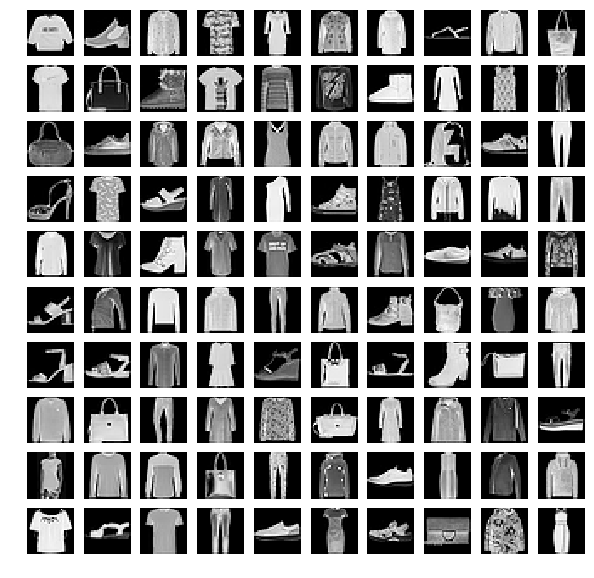

In [6]:
def image_grid(df, converter, rows=10, cols=10):
    f, axes = plt.subplots(rows, cols, figsize=(rows, cols))
    for index, row in df.head(cols * rows).iterrows():
        img = converter(row)
        ax = axes[int(index / cols), index % cols]
        ax.imshow(img)
        ax.axis('off')
    return f

_ = image_grid(train, to_image, rows=10)

In [7]:
def toXy(df):
    """A little function to bridge between the pandas and sklearn worlds"""
    y = df['label'].values
    X = np.delete(df.values, 0, 1)
    return X,y

train_X, train_y = toXy(train)
test_X, test_y = toXy(test)

In [8]:
from sklearn import linear_model
reg = sklearn.linear_model.LogisticRegression(verbose=True,
                                              multi_class='ovr',
                                              solver='saga',
                                              max_iter=100, 
                                              n_jobs=4)
reg.fit(train_X[:8000], train_y[:8000])

max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds


/home/joe/.local/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


max_iter reached after 5 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 6 seconds
max_iter reached after 5 seconds
max_iter reached after 5 seconds


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   16.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=4,
          penalty='l2', random_state=None, solver='saga', tol=0.0001,
          verbose=True, warm_start=False)

In [9]:
reg.score(train_X, train_y)

0.8406166666666667

In [10]:
reg.score(test_X, test_y)

0.8332

In [12]:
from sklearn.metrics import confusion_matrix

yhat = reg.predict(test_X)
confusion_matrix(test_y, yhat)

array([[798,   9,  18,  45,   6,   0,  89,   0,  32,   3],
       [  1, 973,   1,  13,   3,   2,   6,   1,   0,   0],
       [ 17,   0, 740,  13, 135,   0,  85,   0,  10,   0],
       [ 38,  23,  15, 860,  40,   0,  18,   0,   6,   0],
       [  1,   1,  81,  43, 773,   0,  98,   0,   3,   0],
       [  3,   0,   1,   1,   0, 833,   0,  75,  21,  66],
       [154,   7,  98,  41, 110,   0, 562,   0,  28,   0],
       [  0,   0,   0,   0,   0,  36,   0, 907,   1,  56],
       [  4,   0,   9,   4,   6,  10,  19,   5, 940,   3],
       [  0,   0,   0,   0,   1,  15,   0,  36,   2, 946]])

# Multi-Layer Perceptron (MLP)

In [13]:
from sklearn.neural_network import MLPClassifier

net = MLPClassifier(verbose=True, hidden_layer_sizes=(100,100), learning_rate='adaptive')
net.fit(train_X, train_y)

Iteration 1, loss = 3.06230082
Iteration 2, loss = 1.04341267
Iteration 3, loss = 0.71329358
Iteration 4, loss = 0.59855188
Iteration 5, loss = 0.51787246
Iteration 6, loss = 0.48756418
Iteration 7, loss = 0.46491033
Iteration 8, loss = 0.44841891
Iteration 9, loss = 0.42847899
Iteration 10, loss = 0.41321835
Iteration 11, loss = 0.41211178
Iteration 12, loss = 0.40653515
Iteration 13, loss = 0.39606409
Iteration 14, loss = 0.38955682
Iteration 15, loss = 0.39377937
Iteration 16, loss = 0.38411934
Iteration 17, loss = 0.38546174
Iteration 18, loss = 0.39089154
Iteration 19, loss = 0.37834689
Iteration 20, loss = 0.37297777
Iteration 21, loss = 0.37631294
Iteration 22, loss = 0.36429880
Iteration 23, loss = 0.36794136
Iteration 24, loss = 0.35055476
Iteration 25, loss = 0.34422555
Iteration 26, loss = 0.34735133
Iteration 27, loss = 0.34974681
Iteration 28, loss = 0.34528297
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [14]:
net.score(train_X, train_y)

0.8845333333333333

In [15]:
net.score(test_X, test_y)

0.8656

# A simple MLP with TensorFlow

In [73]:
import tensorflow as tf

def mlp_model_fn(features, labels, mode):
    
    # Input layer
    # The -1 is going to adapt to the batch size
    input_layer = tf.reshape(features, [-1, 28 * 28])
    
    # The hidden layer(s)
    hidden1 = tf.layers.dense(inputs=input_layer, units=100, activation=tf.nn.relu)
    hidden2 = tf.layers.dense(inputs=hidden1, units=100, activation=tf.nn.relu)
    
    # Logits output layer
    logits = tf.layers.dense(inputs=hidden2, units=10)
    
    
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # If we're here then mode is EVAL
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

mlp_classifier = tf.estimator.Estimator(model_fn=mlp_model_fn, model_dir="/tmp/mlp_model")
logging_hook = tf.train.LoggingTensorHook(
    tensors={"probabilities": "softmax_tensor"},
    every_n_iter=50
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mlp_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f988a06c278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [90]:
def mlp_model(features, labels, mode):    
    # Input layer
    # The -1 is going to adapt to the batch size
    input_layer = tf.reshape(features, [-1, 28 * 28])
    
    # The hidden layer(s)
    hidden1 = tf.layers.dense(inputs=input_layer, units=100, activation=tf.nn.relu)
    hidden2 = tf.layers.dense(inputs=hidden1, units=100, activation=tf.nn.relu)
 
    return classifier_of(hidden2, labels, mode)

def classifier_of(outputs, labels, mode):
    """Bolt on the plumbing for a classifier model"""

    # Logits output layer
    logits = tf.layers.dense(inputs=outputs, units=10)
        
    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # If we're here then mode is EVAL
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions['classes'])
    }
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

mlp_classifier = tf.estimator.Estimator(model_fn=mlp_model, model_dir="/tmp/mlp_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/mlp_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f988a3a2eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [91]:
# Okay let's train this baby

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=np.float32(train_X),
    y=np.int32(train_y),
    batch_size=1000,
    num_epochs=None,
    shuffle=True
)

mlp_classifier.train(input_fn=train_input_fn, steps=10000) #, hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mlp_model/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30001 into /tmp/mlp_model/model.ckpt.
INFO:tensorflow:loss = 0.1141381, step = 30001
INFO:tensorflow:global_step/sec: 105.27
INFO:tensorflow:loss = 0.0577375, step = 30101 (0.951 sec)
INFO:tensorflow:global_step/sec: 108.511
INFO:tensorflow:loss = 0.061441325, step = 30201 (0.922 sec)
INFO:tensorflow:global_step/sec: 107.767
INFO:tensorflow:loss = 0.06294706, step = 30301 (0.928 sec)
INFO:tensorflow:global_step/sec: 108.207
INFO:tensorflow:loss = 0.055862192, step = 30401 (0.924 sec)
INFO:tensorflow:global_step/sec: 107.844
INFO:tensorflow:loss = 0.081576206, step = 30501 (0.928 sec)
INFO:tensorflow:global_step/sec: 107.519
INFO:tensorflow:lo

In [92]:
def eval_input_fn(X, y):    
    return tf.estimator.inputs.numpy_input_fn(
        x=np.float32(X),
        y=np.int32(y),
        num_epochs=1,
        shuffle=False
    )

print(mlp_classifier.evaluate(input_fn=eval_input_fn(train_X, train_y)))
print(mlp_classifier.evaluate(input_fn=eval_input_fn(test_X, test_y)))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-11:43:46
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mlp_model/model.ckpt-31000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-11:43:47
INFO:tensorflow:Saving dict for global step 31000: accuracy = 0.96748334, global_step = 31000, loss = 0.08930493
{'accuracy': 0.96748334, 'loss': 0.08930493, 'global_step': 31000}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-11:43:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mlp_model/model.ckpt-31000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-11:43:47
INFO:tensorflow:Saving dict for global step 31000:

In [99]:
def cnn_model(features, labels, mode):
    # The -1 is going to adapt to the batch size
    input_layer = tf.reshape(features, [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=[5,5],
                            padding='same',
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2)
    
    flat = tf.reshape(pool1, [-1, 14 * 14 * 32])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
    
    return classifier_of(dense, labels, mode)

cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model, model_dir="/tmp/cnn_model")


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f98af0ddef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [107]:
cnn_classifier.train(input_fn=train_input_fn, steps=1000) #, hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_model/model.ckpt-3002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3003 into /tmp/cnn_model/model.ckpt.
INFO:tensorflow:loss = 0.011549585, step = 3003
INFO:tensorflow:global_step/sec: 1.84999
INFO:tensorflow:loss = 0.012831504, step = 3103 (54.055 sec)
INFO:tensorflow:global_step/sec: 1.75401
INFO:tensorflow:loss = 0.011957303, step = 3203 (57.013 sec)
INFO:tensorflow:global_step/sec: 1.69098
INFO:tensorflow:loss = 0.010619203, step = 3303 (59.137 sec)
INFO:tensorflow:global_step/sec: 1.71965
INFO:tensorflow:loss = 0.0049636615, step = 3403 (58.152 sec)
INFO:tensorflow:global_step/sec: 1.72834
INFO:tensorflow:loss = 0.01096012, step = 3503 (57.858 sec)
INFO:tensorflow:global_step/sec: 1.74796
INFO:tensorflow

In [121]:
# Evaluate!
def get_stats(estimator):
    train = estimator.evaluate(input_fn=eval_input_fn(train_X, train_y))
    test = estimator.evaluate(input_fn=eval_input_fn(test_X, test_y))
    return {'train': train, 'test': test}

get_stats(cnn_classifier)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-13:27:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_model/model.ckpt-4002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-13:27:27
INFO:tensorflow:Saving dict for global step 4002: accuracy = 0.9976, global_step = 4002, loss = 0.008710468
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-13:27:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_model/model.ckpt-4002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-13:27:29
INFO:tensorflow:Saving dict for global step 4002: accuracy = 0.9063, global_step = 4002, loss = 0.5676605


{'train': {'accuracy': 0.9976, 'loss': 0.008710468, 'global_step': 4002},
 'test': {'accuracy': 0.9063, 'loss': 0.5676605, 'global_step': 4002}}

In [114]:
def cnn_model_2(features, labels, mode):
    # The -1 is going to adapt to the batch size
    input_layer = tf.reshape(features, [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=32,
                            kernel_size=[5,5],
                            padding='same',
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=64,
                            kernel_size=[5,5],
                            padding='same',
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2)
    
    flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
    
    return classifier_of(dense, labels, mode)

cnn_classifier_2 = tf.estimator.Estimator(model_fn=cnn_model_2, model_dir="/tmp/cnn_model_2")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/cnn_model_2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9889cfbf98>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [123]:
cnn_classifier_2.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_model_2/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1001 into /tmp/cnn_model_2/model.ckpt.
INFO:tensorflow:loss = 0.12113048, step = 1001
INFO:tensorflow:global_step/sec: 0.943735
INFO:tensorflow:loss = 0.12154638, step = 1101 (105.963 sec)
INFO:tensorflow:global_step/sec: 0.936775
INFO:tensorflow:loss = 0.13149443, step = 1201 (106.749 sec)
INFO:tensorflow:global_step/sec: 0.91585
INFO:tensorflow:loss = 0.10441443, step = 1301 (109.188 sec)
INFO:tensorflow:global_step/sec: 0.930621
INFO:tensorflow:loss = 0.11976243, step = 1401 (107.455 sec)
INFO:tensorflow:global_step/sec: 0.93068
INFO:tensorflow:loss = 0.11969529, step = 1501 (107.448 sec)
INFO:tensorflow:Saving checkpoints for 1560 into /

In [124]:
get_stats(cnn_classifier_2)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-13:54:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_model_2/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-13:55:00
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9615333, global_step = 2000, loss = 0.10294022
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-13:55:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/cnn_model_2/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-13:55:03
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9055, global_step = 2000, loss = 0.37107858


{'train': {'accuracy': 0.9615333, 'loss': 0.10294022, 'global_step': 2000},
 'test': {'accuracy': 0.9055, 'loss': 0.37107858, 'global_step': 2000}}

'/tmp/cnn_model_2'